In [37]:
import pandas as pd

# 确保所有列都能显示出来
pd.set_option('display.max_columns', 500)

# 确保列宽足够，不会把长字符串（比如 Method 名）截断
pd.set_option('display.max_colwidth', 100)

# 确保表格的总宽度足够，不会换行显示
pd.set_option('display.width', 1000)

In [38]:
TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

METRIC_NAME_MAP = {
    'eval_matthews_correlation': 'Mcc',
    'matched_accuracy': 'm',
    'mismatched_accuracy': 'mm',
    'eval_accuracy': 'Acc',
    'eval_f1': 'F1',
    'eval_pearson': 'Corr_p',
    'eval_spearman': 'Corr_s',
}

TASK_NAME_MAP = {
    'mnli': 'MNLI',
    'sst2': 'SST-2',
    'cola': 'CoLA',
    'qqp': 'QQP',
    'qnli': 'QNLI',
    'rte': 'RTE',
    'mrpc': 'MRPC',
    'stsb': 'STS-B',
}

FAMILY_NAME_MAP = {
    'bert': 'BERT-b',
    'roberta': 'RoB-b',
    'deberta': 'DeB-b',
}

METHOD_NAME_MAP = {
    'lora': 'LoRA',
    'olora': 'OLoRA',
    'dora': 'DoRA',
    'mrlora': 'MR-LoRA',
    'adalora': 'AdaLoRA',
    'mrlora-rs': 'MR-LoRA-RS',
    'rslora': 'RS-LoRA'
}
VARIANT_NAME_MAP = {
    'fft': 'FFT',
    'lora': 'LoRA-Finetuning',
    'kd-lora': 'KD-LoRA-Finetuning'
}

REMOVE_PEFT = ['mrlora-rs']

In [39]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import  NA

def extract_experiment_data(json_file, root_dir):
    variant = Path(json_file).relative_to(root_dir).parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    # for mnli, need patching.
    if 'eval_runtime' in data:
        eval_runtime = data.get('eval_runtime')
    else:
        eval_runtime_history = []
        for item in data['log_history']:
            if 'eval_runtime' in item:
                eval_runtime_history.append(item['eval_runtime'])
        eval_runtime = sum(eval_runtime_history) / len(eval_runtime_history)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', NA)
    train_runtime = dictor(data, 'train.train_time', NA)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else NA

    rank = dictor(data, 'args.rank')

    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
                'path': str(json_file)
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f, root_dir)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./ablation/')

In [40]:
df.family.unique()

array(['roberta'], dtype=object)

In [41]:
df.peft.unique()

array(['mrlora', 'mrlora-olora-lcoef', 'mrlora-olora-rs', 'mrlora-rs',
       'mrlora-lcoef', 'mrlora-olora'], dtype=object)

In [42]:
df['rank'].unique()

array([8])

In [43]:
df.task.unique()

array(['qqp'], dtype=object)

In [44]:
df.groupby('task').count()

,family,peft,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed,path
task,,,,,,,,,,,,
qqp,12,12,12,12,12,12,12,12,12,12,12,12


In [45]:
df.metric.unique()

array(['eval_accuracy', 'eval_f1'], dtype=object)

In [46]:
df.seed.unique()

array([42])

In [47]:
df.variant.unique()

array(['lora'], dtype=object)

In [48]:
df.params.unique()

array([0.887 , 0.8871])

In [49]:
df[df.metric == 'mismatched_accuracy'].describe()

,value,params,traintime,evaltime,gpumem,rank,seed
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df[(df.metric == 'eval_f1') & (df.value == 0.0)]

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed,path


In [51]:
df_simple = df.drop(columns=['seed', 'family', 'params', 'rank', 'variant'])[df.task != 'stsb']
df_simple = df_simple[df.metric != 'eval_f1']

In [52]:
import pandas as pd
import seaborn as sns

# 1. Expand the 'peft' strings into feature columns
features = [ 'rs', 'lcoef', 'olora', 'bias', ]

for f in features:
    # Checks if the feature name exists as a standalone word in the string
    df_simple[f] = df_simple['peft'].apply(lambda x: f in x.split('-'))

# 2. Create a Pivot Table
# We group by the feature flags and show the mean 'value' for each 'task'
pivot_df = df_simple.pivot_table(
    index=features,
    columns='task',
    values='value',
    aggfunc='mean'
)

# 3. Apply Styling (Conditional Formatting)
styled_table = pivot_df.style.background_gradient(axis=0, cmap='YlGnBu') \
                             .format("{:.4f}") \
                             .set_caption("MrLoRA Feature Ablation Study")

# Display in Jupyter/Colab
styled_table

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of features to isolate
features = ['olora', 'rs', 'lcoef']

# Create boolean columns: True if feature name is in the 'peft' string
for f in features:
    df_simple[f] = df_simple['peft'].apply(lambda x: f in x.split('-'))

In [54]:
impact_results = []

for f in features:
    # Calculate Mean for 'On' vs 'Off' across all tasks
    summary = df_simple.groupby(f)['value'].mean()
    impact_results.append({
        'Feature': f,
        'Off_Avg': summary[False],
        'On_Avg': summary[True],
        'Delta': summary[True] - summary[False]
    })

df_impact = pd.DataFrame(impact_results)
print(df_impact)

  Feature   Off_Avg    On_Avg   Delta
0   olora  0.869567  0.867367 -0.0022
1      rs  0.868500  0.868400 -0.0001
2   lcoef  0.867900  0.869600  0.0017


1. bias cause obvious drop.
2. rs and lcoef boost perf.

/var/folders/82/tr0t3jp906z8k_q9pbcg_jd40000gn/T/ipykernel_62924/1667137800.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


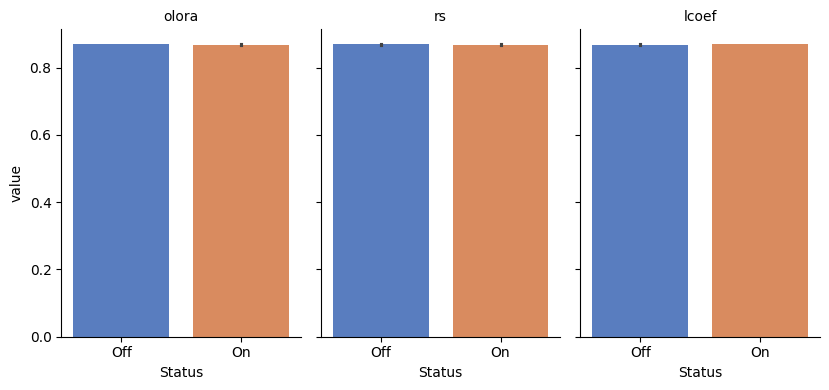

In [55]:
# Melt the data for visualization
plot_data = []
for f in features:
    subset = df_simple[[f, 'value', 'task']].copy()
    subset['Feature_Name'] = f
    subset = subset.rename(columns={f: 'Status'})
    subset['Status'] = subset['Status'].map({True: 'On', False: 'Off'})
    plot_data.append(subset)

df_plot = pd.concat(plot_data)

# Create a FacetGrid to see On/Off for each feature across tasks
g = sns.catplot(
    data=df_plot, x='Status', y='value',
    col='Feature_Name', kind='bar',
    palette='muted', height=4, aspect=0.7
)
g.set_titles("{col_name}")


In [56]:
impact_results = []

for f in features:
    # Calculate Mean for 'On' vs 'Off' across all tasks
    summary = df_simple.groupby(f)['traintime'].mean()
    impact_results.append({
        'Feature': f,
        'Off_Avg': summary[False],
        'On_Avg': summary[True],
        'Delta': summary[True] - summary[False]
    })

df_impact = pd.DataFrame(impact_results)
print(df_impact)

  Feature      Off_Avg    On_Avg      Delta
0   olora  1771.103333  1818.730  47.626667
1      rs  1782.037500  1820.675  38.637500
2   lcoef  1796.522500  1791.705  -4.817500


1. bias cuts traintime? The perf stop enhancing too early!
2. rs and lcoef add little train time!

In [57]:
df_simple.traintime.unique() # Has influence on traintime.

array([1775.22, 1879.59, 1807.08, 1834.27, 1703.82, 1769.52])

In [58]:
impact_results = []

for f in features:
    # Calculate Mean for 'On' vs 'Off' across all tasks
    summary = df_simple.groupby(f)['gpumem'].mean()
    impact_results.append({
        'Feature': f,
        'Off_Avg': summary[False],
        'On_Avg': summary[True],
        'Delta': summary[True] - summary[False]
    })

df_impact = pd.DataFrame(impact_results)
print(df_impact)

  Feature  Off_Avg  On_Avg  Delta
0   olora  531.570  531.57  0.000
1      rs  531.750  531.21 -0.540
2   lcoef  531.735  531.24 -0.495


In [59]:
df_simple.gpumem.unique() # Almost the same.

array([532.26, 531.24, 531.21])

## Compare with SOTA

In [60]:
df_base = aggregate_experiment_results('./results')
df_base = df_base[df_base.variant == 'lora']
df_base = df_base[df_base.task.isin(df.task.unique())]
df_base = df_base[df_base.family.isin(df.family.unique())]
df_base = df_base[df_base.seed == 42]

In [61]:
df_our = df

In [62]:
df_our.sort_values('value', ascending=False)

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed,path
8,roberta,mrlora-lcoef,qqp,lora,0.8700,eval_accuracy,0.8871,1703.82,12.20,531.24,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-lcoef_16_0.05_8/metrics.json
6,roberta,mrlora-rs,qqp,lora,0.8697,eval_accuracy,0.8870,1834.27,12.82,531.21,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-rs_16_0.05_8/metrics.json
2,roberta,mrlora-olora-lcoef,qqp,lora,0.8692,eval_accuracy,0.8871,1879.59,10.56,531.24,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-olora-lcoef_16_0.05_8/metrics.json
0,roberta,mrlora,qqp,lora,0.8690,eval_accuracy,0.8870,1775.22,10.04,532.26,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora_16_0.05_8/metrics.json
4,roberta,mrlora-olora-rs,qqp,lora,0.8671,eval_accuracy,0.8870,1807.08,10.31,531.21,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-olora-rs_16_0.05_8/metrics.json
10,roberta,mrlora-olora,qqp,lora,0.8658,eval_accuracy,0.8870,1769.52,12.14,532.26,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-olora_16_0.05_8/metrics.json
7,roberta,mrlora-rs,qqp,lora,0.8338,eval_f1,0.8870,1834.27,12.82,531.21,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-rs_16_0.05_8/metrics.json
3,roberta,mrlora-olora-lcoef,qqp,lora,0.8298,eval_f1,0.8871,1879.59,10.56,531.24,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-olora-lcoef_16_0.05_8/metrics.json
9,roberta,mrlora-lcoef,qqp,lora,0.8270,eval_f1,0.8871,1703.82,12.20,531.24,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora-lcoef_16_0.05_8/metrics.json
1,roberta,mrlora,qqp,lora,0.8254,eval_f1,0.8870,1775.22,10.04,532.26,8,42,ablation/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_mrlora_16_0.05_8/metrics.json


In [63]:
df_base.sort_values('value', ascending=False)

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed,path
1486,roberta,olora,qqp,lora,0.8632,eval_accuracy,0.8870,1754.58,14.68,534.59,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_olora_16_0.05_8/metrics.json
1490,roberta,dora,qqp,lora,0.8615,eval_accuracy,0.9055,2235.78,12.15,534.09,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_dora_16_0.05_8/metrics.json
1484,roberta,lora,qqp,lora,0.8505,eval_accuracy,0.8870,1238.98,14.06,533.81,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_lora_16_0.05_8/metrics.json
1482,roberta,rslora,qqp,lora,0.8504,eval_accuracy,0.8870,1091.74,8.90,534.59,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_rslora_16_0.05_8/metrics.json
1487,roberta,olora,qqp,lora,0.8287,eval_f1,0.8870,1754.58,14.68,534.59,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_olora_16_0.05_8/metrics.json
1491,roberta,dora,qqp,lora,0.8225,eval_f1,0.9055,2235.78,12.15,534.09,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_dora_16_0.05_8/metrics.json
1483,roberta,rslora,qqp,lora,0.8130,eval_f1,0.8870,1091.74,8.90,534.59,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_rslora_16_0.05_8/metrics.json
1485,roberta,lora,qqp,lora,0.8104,eval_f1,0.8870,1238.98,14.06,533.81,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_lora_16_0.05_8/metrics.json
1488,roberta,adalora,qqp,lora,0.6318,eval_accuracy,1.1823,293.23,11.24,538.20,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_adalora_16_0.05_8/metrics.json
1489,roberta,adalora,qqp,lora,0.0000,eval_f1,1.1823,293.23,11.24,538.20,8,42,results/lora/task_qqp_roberta_42/base_32_2e-05_0.01/peft_adalora_16_0.05_8/metrics.json
